In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud

In [5]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./evaluation.csv')

In [6]:
train.head()

,storeId,url,additionalAttributes,breadcrumbs,label
0,23,http://www.walmart.com/ip/best-of-toto%3A-pian...,Contributed by=Toto;Format=Paperback;Number of...,books > art music & photography > music,books
1,NaN,NaN,NaN,best buy > computers & tablets > computer card...,rest
2,23,https://www.walmart.com/ip/34441317,Performer=Cult Of Youth;Record Label=Vinyl;1.=...,music on cd or vinyl > rock music on cd or vin...,music
3,26,https://www.overstock.com/Books-Movies-Music-G...,Format=Paperback;Copyright Year=2000;Publisher...,books & media > books > cooking & food books >...,books
4,22,http://www.target.com/p/amore-version-ii/-/A-1...,Store Item Number (DPCI)=244-48-2721;Origin=Ma...,"target > movies, music & books > music > class...",music


# Exploratory Data Analysis

Let's see how the labels are distributed

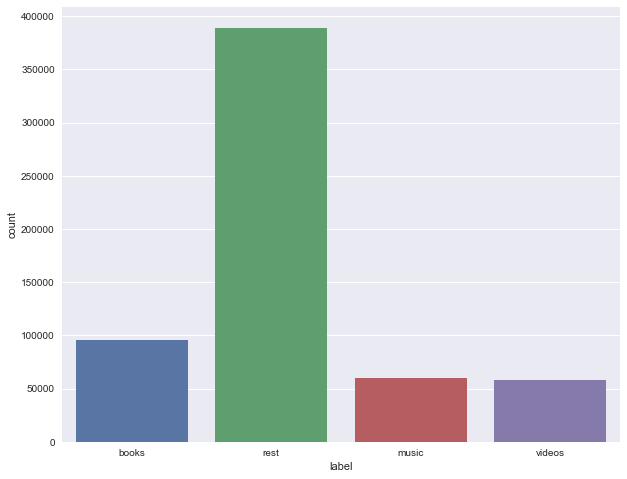

(' Distribution of each label : \n', rest      389250
books      95811
music      59996
videos     58144
Name: label, dtype: int64)


In [7]:
plt.figure(figsize=(10,8))
sns.countplot(train.label)
plt.show()

print( " Distribution of each label : \n" , train.label.value_counts())

Looks like more items are in "rest" category

Lets now remove all the special characters in additional attributes and breadcrumbs

In [8]:
def removeSpecialCharacters(x):
    try:
        text = re.sub('[^a-zA-Z0-9-_*.]', ' ', x)
        return text
    except:
        return ' '

In [9]:
train.additionalAttributes = train.additionalAttributes.apply(lambda x : removeSpecialCharacters(x))
test.additionalAttributes = test.additionalAttributes.apply(lambda x : removeSpecialCharacters(x))

In [10]:
train.breadcrumbs = train.breadcrumbs.apply(lambda x : removeSpecialCharacters(x))
test.breadcrumbs = test.breadcrumbs.apply(lambda x : removeSpecialCharacters(x))

In [11]:
train.head()

,storeId,url,additionalAttributes,breadcrumbs,label
0,23,http://www.walmart.com/ip/best-of-toto%3A-pian...,Contributed by Toto Format Paperback Number of...,books art music photography music,books
1,NaN,NaN,,best buy computers tablets computer card...,rest
2,23,https://www.walmart.com/ip/34441317,Performer Cult Of Youth Record Label Vinyl 1. ...,music on cd or vinyl rock music on cd or vin...,music
3,26,https://www.overstock.com/Books-Movies-Music-G...,Format Paperback Copyright Year 2000 Publisher...,books media books cooking food books ...,books
4,22,http://www.target.com/p/amore-version-ii/-/A-1...,Store Item Number DPCI 244-48-2721 Origin Ma...,target movies music books music class...,music


### Feature Engineering

Now lets create a new fetaure called description which is the combination of addditional attributes and breadcrumbs

In [12]:
train['descsription'] = train.additionalAttributes + train.breadcrumbs
test['descsription'] = test.additionalAttributes + test.breadcrumbs

Now let's create 4 different dataframes and analyze them to see what kind of words are used majorly in each categories

In [13]:
books_df = train[train.label == 'books']
music_df = train[train.label == 'music']
videos_df = train[train.label == 'videos']
rest_df = train[train.label == 'rest']

Lets use wordcloud and see what are the major words used in each category

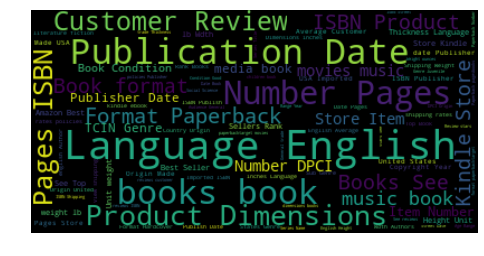

In [18]:
books_desc = books_df["descsription"].str.cat(sep = " ")
books_wordcloud = WordCloud().generate(books_desc)
plt.imshow(books_wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()


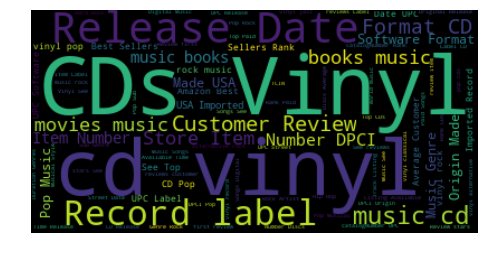

In [19]:
music_desc = music_df["descsription"].str.cat(sep = " ")
music_wordcloud = WordCloud().generate(music_desc)
plt.imshow(music_wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

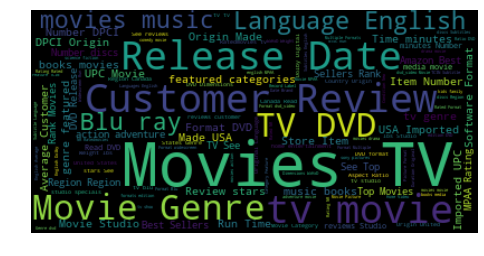

In [20]:
videos_desc = videos_df["descsription"].str.cat(sep = " ")
videos_wordcloud = WordCloud().generate(videos_desc)
plt.imshow(videos_wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

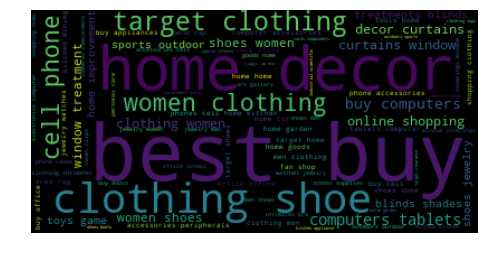

In [21]:
rest_desc = rest_df["descsription"].str.cat(sep = " ")
rest_wordcloud = WordCloud().generate(rest_desc)
plt.imshow(rest_wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

Looks like all the categories have some key words which are used in most of the description
Let's see how the word "Movies" are distributed in wach category

In [25]:
print("Count of word 'Movies' in videos cat",videos_desc.count("Movies"))
print("Count of word 'Movies' in videos cat",books_desc.count("Movies"))
print("Count of word 'Movies' in videos cat",music_desc.count("Movies"))
print("Count of word 'Movies' in videos cat",rest_desc.count("Movies"))

("Count of word 'Movies' in videos cat", 47971)
("Count of word 'Movies' in videos cat", 157)
("Count of word 'Movies' in videos cat", 928)
("Count of word 'Movies' in videos cat", 0)


You can see how the word movies are distributed among different categories.

Seeing these data , I would go ahead with Bag of Words Approach with ngram range (1) , because I see that each category is heavily dependent on each of these key words

### Pre-processing

In [26]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

Let's first make the labels into numerical categories by using Label Encoder

In [27]:
le = LabelEncoder()
le.fit(train.label)
train.label = le.transform(train.label)

In [28]:
vect = CountVectorizer()
vect.fit(train.descsription)
X = vect.transform(train.descsription)
y= train.label

Using train_test_split for spliting the training data into test and train data

In [29]:
X_train , X_test , y_train , y_test = train_test_split(X , y)

In [30]:
print(X_train.shape)
print(X_test.shape)

(452400, 379731)
(150801, 379731)


### Model Selection

I am going to start with Linear models, because in my experience with considerable amount of data and features , linear model tend to be fast and give good results.

In [31]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

In [32]:
clf.fit(X_train , y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [33]:
y_pred = clf.predict(X_test)

In [34]:
print("Accuracy score : - " , accuracy_score(y_pred , y_test))

('Accuracy score : - ', 0.99984748111749921)


Accuracy of 99.99% ... Looks like the approach is giving awesome result.

Still there is a small chance that the X_test generated was perfectly fit for the portion of test set created. To verify that no overfitting has happened in the model , I will use cross_val_score

### Cross - Validation

In [35]:
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(clf , X_train , y_train)

/Users/i309911/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [36]:
print (np.mean(scores))

0.999847480062


### Parameter Tuning

Let's see if we can improve the score by tuning the parameters

In [38]:
from sklearn.grid_search import GridSearchCV
params = { 'C' : [0.1 , 1 , 10]}
grid =  GridSearchCV(clf , params)
grid.fit(X_train , y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1, param_grid={'C': [0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [39]:
print " Best Score ", grid.best_score_
print " Best params", grid.best_params_

 Best Score  0.999874005305
 Best params {'C': 10}


### Final Model

In [40]:
clf = LogisticRegression(C=10)
clf.fit(X_train , y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [41]:
X_test = vect.transform(test.descsription)
y_final = clf.predict(X_test)

In [42]:
test['label'] = y_final

In [43]:
test['label'] = le.inverse_transform(y_final)

In [44]:
test

,storeId,url,additionalAttributes,breadcrumbs,id,descsription,label
0,NaN,NaN,,baby products bathing skin care washclot...,8589934592,baby products bathing skin care washclo...,rest
1,NaN,NaN,,online shopping home garden art gal...,8589934593,online shopping home garden art ga...,rest
2,NaN,NaN,,home goods kitchen dining table linens ...,8589934594,home goods kitchen dining table linens ...,rest
3,NaN,NaN,,11320,8589934595,11320,rest
4,NaN,NaN,,tools home improvement kitchen bath fixt...,8589934596,tools home improvement kitchen bath fix...,rest
5,NaN,NaN,,best buy cameras camcorders digital came...,8589934597,best buy cameras camcorders digital cam...,rest
6,NaN,NaN,,clothing boys boys jackets outerwear,8589934598,clothing boys boys jackets outerwear,rest
7,NaN,NaN,,target clothing women s clothing ...,8589934599,target clothing women s clothing ...,rest
8,NaN,NaN,,target sports fitness outdoors fan shop...,8589934600,target sports fitness outdoors fan sho...,rest
9,NaN,NaN,,toys games,8589934601,toys games,rest


In [45]:
test.to_csv('./submissions.csv' , index=False)